# Notebook on how to check your fMRI data

Authors: Eduarda Centeno
    
The goal is to show how to work with matrices, how to plot and what to check.


#### Let's start with the necessary packages for the following computations:

    Requirements: 
    
    - Python: 3.7.3
    - Numpy: 1.16.3
    - Matplotlib: 3.2.1
    - Seaborn: 0.10.1
    - Pandas: 1.0.3
    - JupyterLab: 1.2.0
    
    
    


In [1]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

### Some key tips:

    - You should check if there are NaNs, zeros, infs in the matrix.
    - If using AAL -- work only with the 78 first regions.
    - We usually remove regions that have less than 5 voxels of signal (e.g. orbitofrontal regions)
    - If working with matrices of the same size (might differ if removing regions because of tumor, for example), one can average them out and plot:
        - Correlation strenght distrubution
        - Check correlations for the Default Mode Network
    - Connectivity matrix should show 3 diagonals
    - Usually there are clusters around the central diagonal that indicate modularity. Whereas the 2 other diagionals indicate inter-hemispheric connections
    - Lower connectivity values can indicate a lower signal originally.
    - We also work with normalized matrices for final analysis (Absolutize > Z-score > Rescale)

In [17]:
# Import the example matrix
matfinal = np.genfromtxt('randMat.txt')

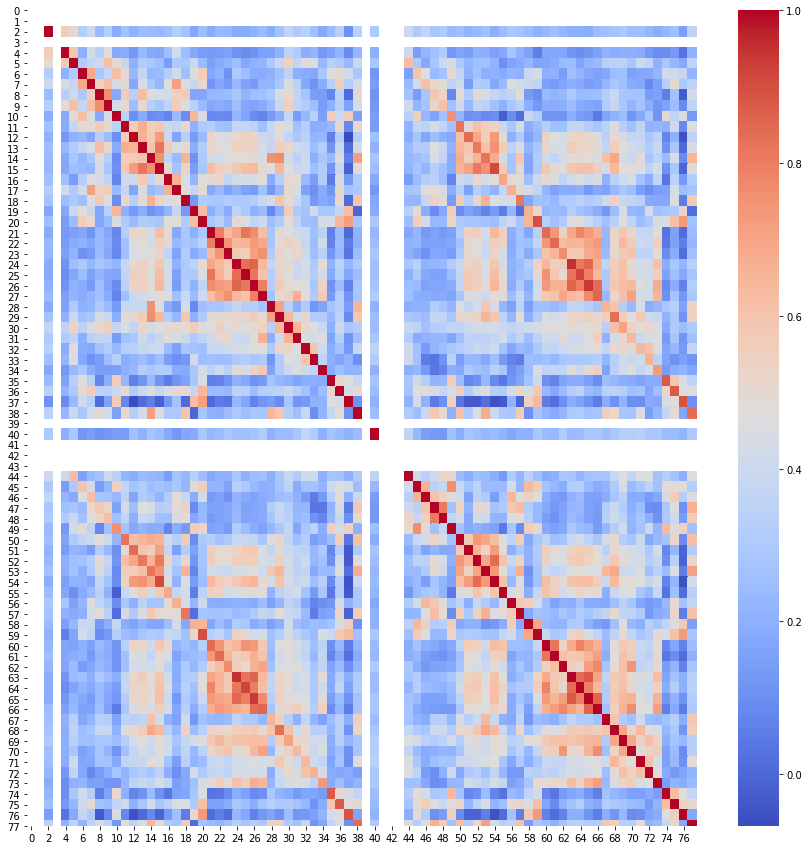

In [30]:
# Visualize entire matrix in its raw form
plt.figure(figsize=(15,15))
sns.heatmap(matfinal, cmap='coolwarm')

##### As mentioned above, some regions might have to be removed do to a lack of signal. One can see these regions here as totally white columns or rows. Thus, it is necessary to remove them.

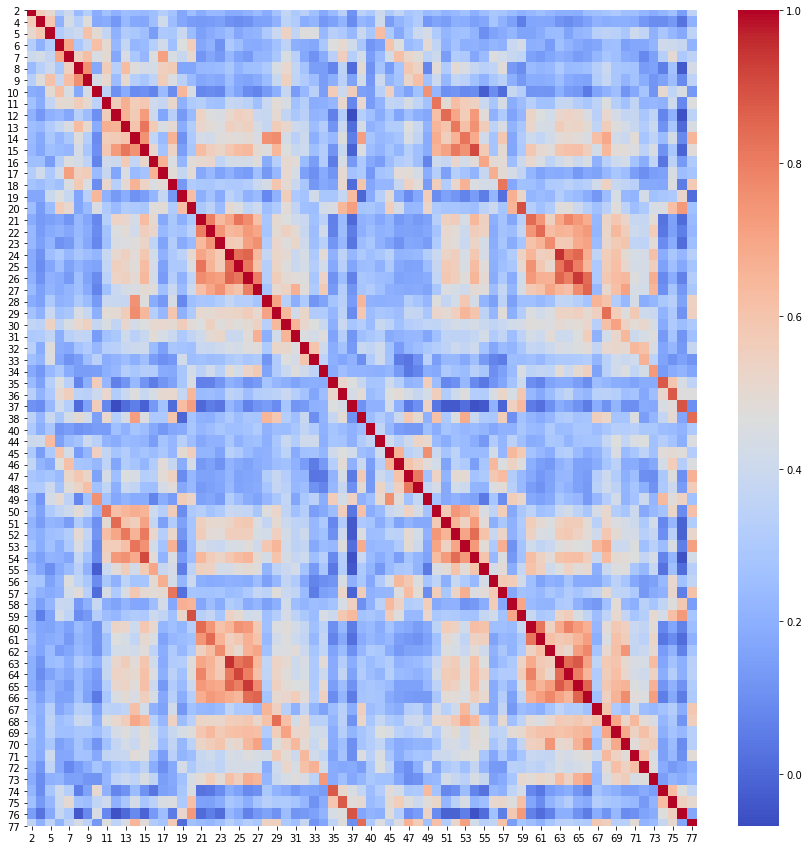

In [31]:
df  = pd.DataFrame(matfinal)
matdropped = df.dropna(axis=1, how='all').dropna(axis=0,how='all')
plt.figure(figsize=(15,15))
sns.heatmap(matdropped, cmap='coolwarm')

Now, one does not see these blank spaces anymore. One can also check how the matrice will not have NaNs anymore. 
As discussed above, it is possible to see 3 clear diagonals in the matrix. 


##### Now let's plot distribution plots.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()


[Text(0.5, 0, 'log(weights)')]

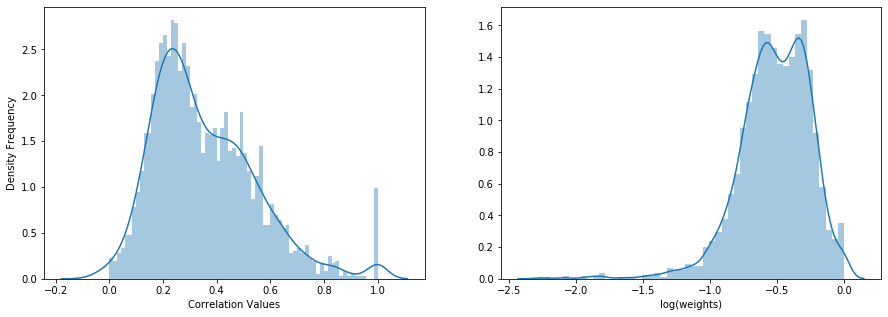

In [38]:
# Weight distribution plot
bins=np.arange(np.sqrt(len(np.concatenate(matdropped.values))))
bins = (bins - np.min(bins))/np.ptp(bins)
fig, axes = plt.subplots(1,2, figsize=(15,5))

# Distribution of raw weights
rawdist = sns.distplot(matdropped.values.flatten(), bins=bins, kde=True, ax=axes[0])
rawdist.set(xlabel='Correlation Values', ylabel = 'Density Frequency')

# Probability density of log10
log10dist = sns.distplot(np.log10(matdropped.values).flatten(), kde=True, ax=axes[1])
log10dist.set(xlabel='log(weights)')

##### Now let's have a look at the DMN

(24, 0)

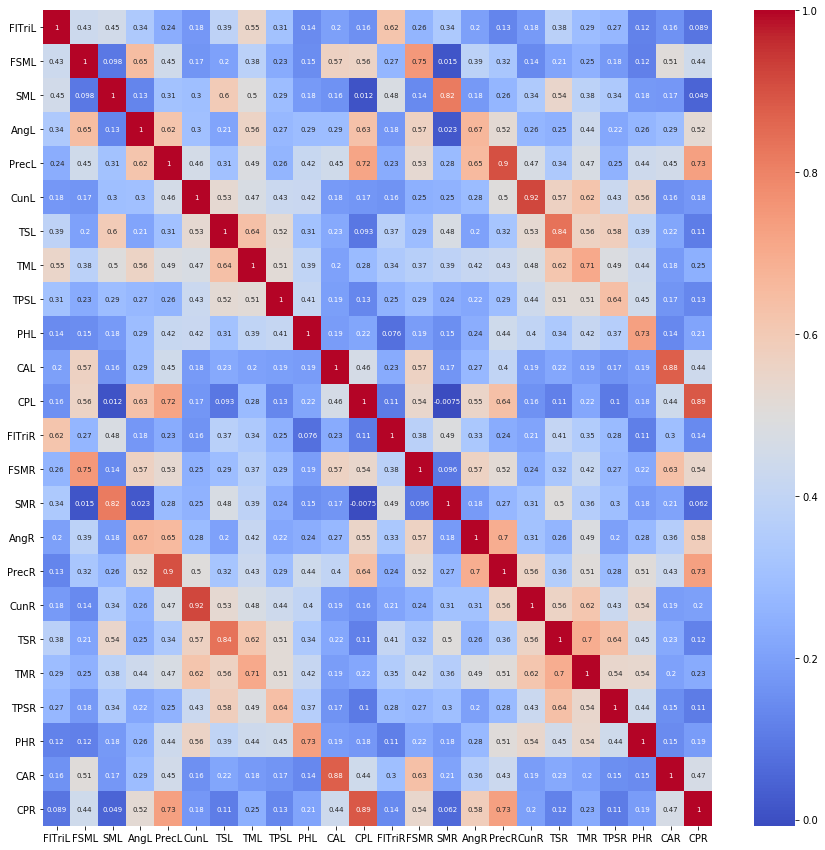

In [22]:
#Checking DMN
regs = np.loadtxt('./yeo_7networks_aal_order.txt', dtype=int)
names = [line.rstrip('\n') for line in open('./AREAS.txt')]
dmn = np.where(regs==7)[0]
    
dfDMN = df[dmn].iloc[dmn]
dfDMN = dfDMN.dropna(axis=1, how='all').dropna(axis=0,how='all')
   
plt.figure(figsize=(15,15))
ax = sns.heatmap(dfDMN, cmap='coolwarm', annot=True, annot_kws = {"size":7})
labels = [value.get_text() for value in list(ax.get_xticklabels())]
labelsy = [value.get_text() for value in list(ax.get_yticklabels())]
ax.set_yticklabels(pd.DataFrame(names).iloc[labelsy][0], rotation=0)
ax.set_xticklabels(pd.DataFrame(names).iloc[labels][0])
ax.set_xlim(0, len(dfDMN))
ax.set_ylim(len(dfDMN), 0)

An area that is usually evaluated to check for DMN connectivity is the precuneus (PrecR or L), and here we can indeed see a strong connection between them. Other than, that the whole diagonal that includes these DMN areas show, overall, strong connectivity. 

#### It is common practice to work with normalized matrices to overcome variability between scans, so now we will do the same as above, but now applying the normalization function.

In [23]:
def normalize(matrix): # Absolutize > Zscore > Rescale 
    """
    This function is supposed to normalize the matrices by first absolutizing it abs();
    Another important step is that we need to send the diagonal to NaN to not skew the mean/std.
    Then we compute a Z-score based on the matrix's mean and std. Taking into consideration that NaNs are present, we will use
    np.nanmean() and np.nanstd(). 
    Finally I rescale the matrix between 0 and 1 according to https://stats.stackexchange.com/questions/70801/how-to-normalize-data-to-0-1-range
    
    Arguments:
        matrix = numpy matrix
        
    Output: 
        zscored matrix & rescaled matrix
    """
    
    matrixabs = abs(matrix)
    np.fill_diagonal(matrixabs, np.nan)
    zmatrix = (matrixabs - np.nanmean(matrixabs))/np.nanstd(matrixabs)
    rescaled = (zmatrix - np.nanmin(zmatrix))/(np.nanmax(zmatrix)- np.nanmin(zmatrix))
    return zmatrix, rescaled

In [24]:
def checknorm(matrix, zmatrix, rescaled):
    """
    To double-check normalization function.
    
    Arguments:
        matrix = numpy matrix
        zmatrix = zscored version of matrix
        rescaled = rescaled version of matrix
        
    Output: 
        Plots of each matrix and its distribution.
    """
    fig,ax = plt.subplots(2,3, figsize=(25,15))
    sns.heatmap(matrix, cmap='coolwarm', ax=ax[0,0])
    sns.heatmap(zmatrix, cmap='coolwarm', ax=ax[0,1])
    sns.heatmap(rescaled, cmap='coolwarm', ax=ax[0,2])
    ax[0,0].set_ylim(len(matrix),0)
    ax[0,1].set_ylim(len(matrix),0)
    ax[0,2].set_ylim(len(matrix),0)
    sns.distplot(matrix.flatten(), kde=True, ax=ax[1,0])
    ax[1,0].set_xlabel('Raw Weights')
    sns.distplot(zmatrix.flatten(), kde=True, ax=ax[1,1])
    ax[1,1].set_xlabel('Z-Scored Weights')
    sns.distplot(rescaled.flatten(), kde=True, ax=ax[1,2])
    ax[1,2].set_xlabel('Normalized Weights')
    ax[0,0].set_title('Raw Matrix')
    ax[0,1].set_title('Z-Scored Matrix')
    ax[0,2].set_title('Rescaled Matrix')

###### Let's just observe in more detail the normalization process.

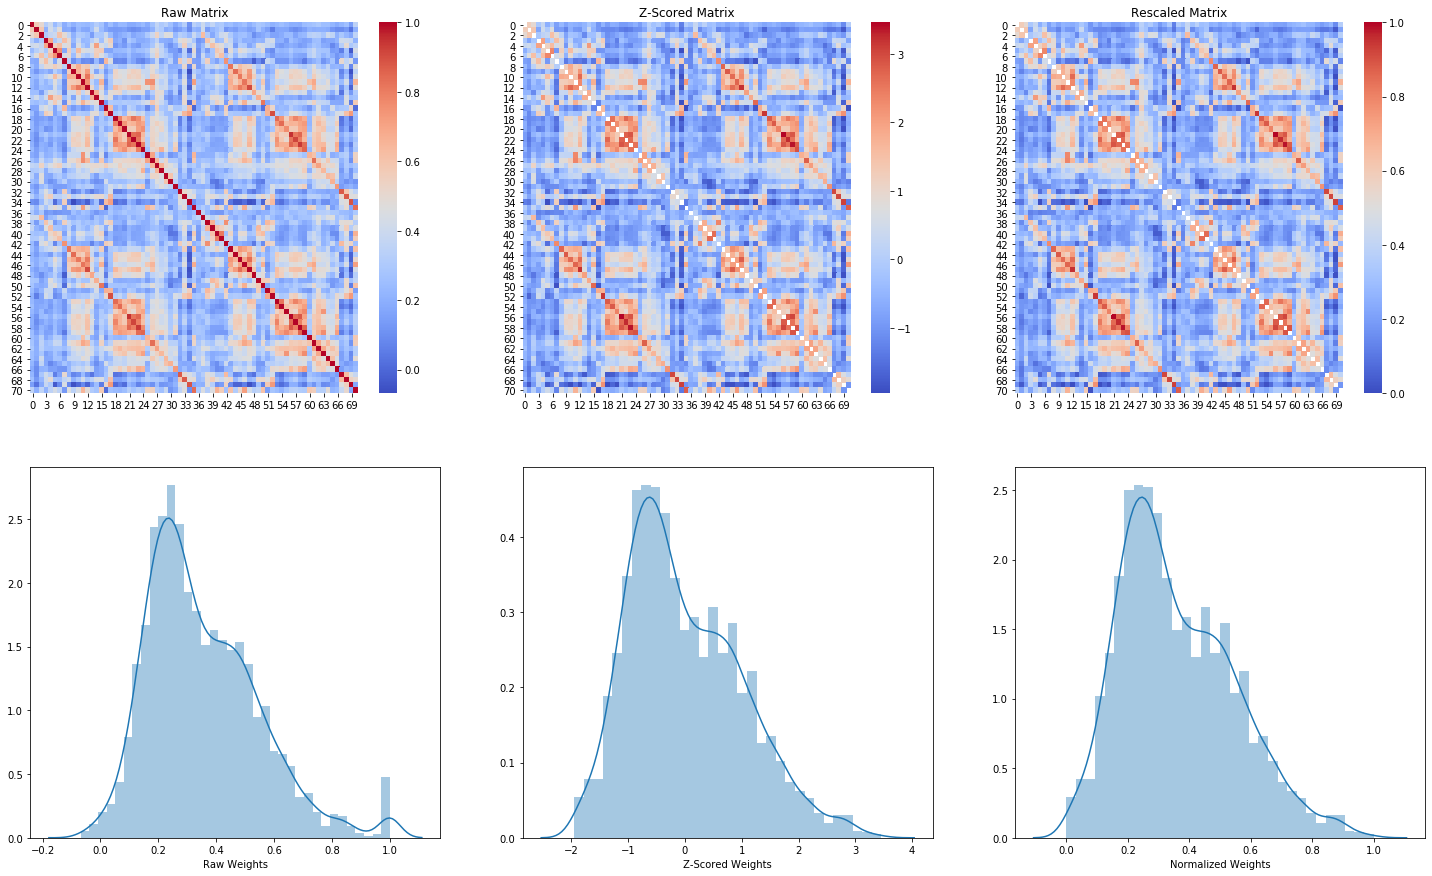

In [28]:
zmatrix, rescaled = normalize(matdropped.values)
checknorm(matdropped.values, zmatrix, rescaled)

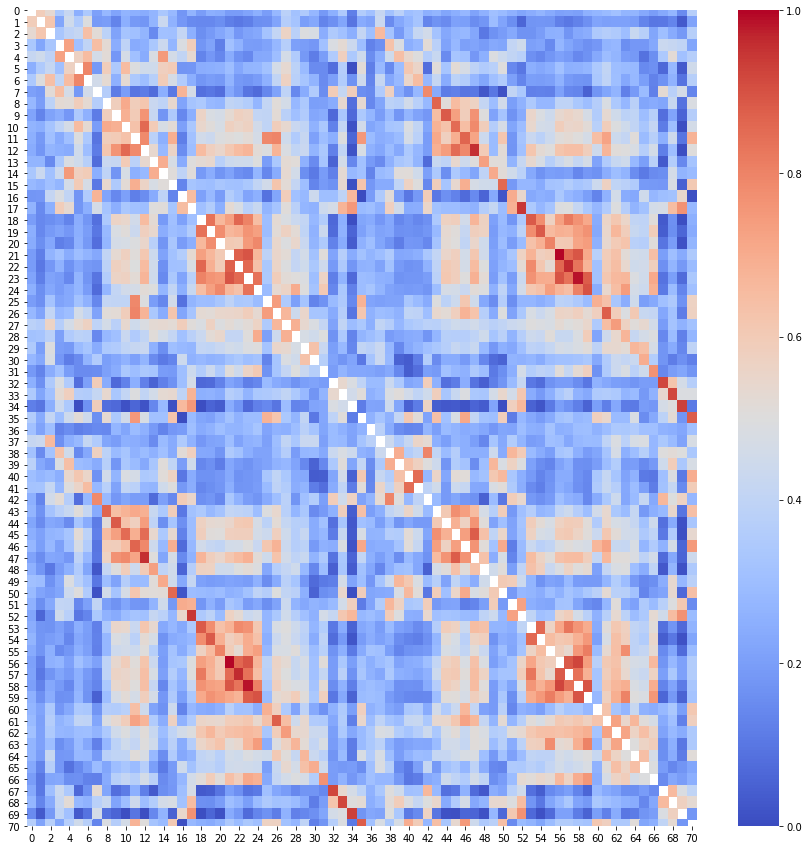

In [29]:
# 'Zoom on' NORMALIZED matrix
plt.figure(figsize=(15,15))
sns.heatmap(rescaled, cmap = 'coolwarm')

(24, 0)

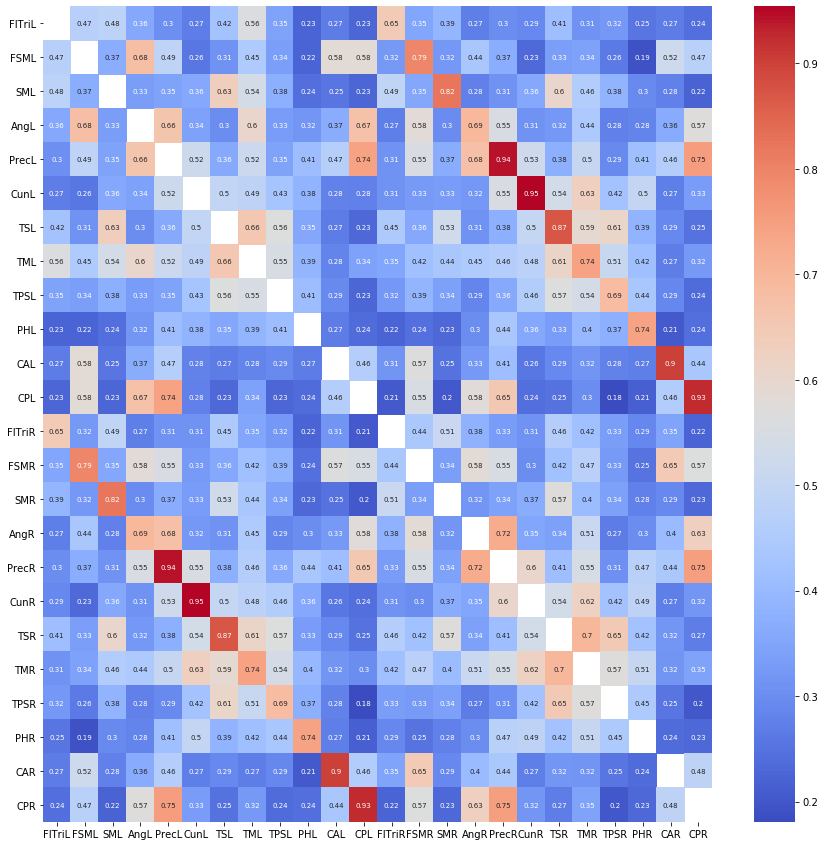

In [56]:
#Checking DMN in NORMALIZED matrix
regs = np.loadtxt('./yeo_7networks_aal_order.txt', dtype=int)
names = [line.rstrip('\n') for line in open('./AREAS.txt')]
dmn = np.where(regs==7)[0]
    
dfDMN = df3[dmn].iloc[dmn]
dfDMN = dfDMN.dropna(axis=1, how='all').dropna(axis=0,how='all')
   
plt.figure(figsize=(15,15))
ax = sns.heatmap(dfDMN, cmap='coolwarm', annot=True, annot_kws = {"size":7})
labels = [value.get_text() for value in list(ax.get_xticklabels())]
labelsy = [value.get_text() for value in list(ax.get_yticklabels())]
ax.set_yticklabels(pd.DataFrame(names).iloc[labelsy][0], rotation=0)
ax.set_xticklabels(pd.DataFrame(names).iloc[labels][0])
ax.set_xlim(0, len(dfDMN))
ax.set_ylim(len(dfDMN), 0)